<a href="https://colab.research.google.com/github/ThisIsFarhan/Langgraph-tutorials/blob/main/2_Chaing_Tool_Calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install langchain_groq langchain_core langgraph

#Messages

In [41]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


#Chat Models LLM

In [42]:
from google.colab import userdata
from langchain_groq import ChatGroq

groq_api_key=userdata.get('groq_api_key')
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.3-70b-versatile")
response = llm.invoke(messages)

In [52]:
response

AIMessage(content="Seeing Orcas (also known as Killer Whales) in their natural habitat can be a thrilling experience. In the US, one of the best places to see Orcas is in the Pacific Northwest, particularly in the waters surrounding the San Juan Islands in Washington State.\n\nThe San Juan Islands are located off the coast of Seattle and are known for their abundant marine wildlife, including three pods of resident Orcas. These Orcas, also known as the Southern Resident Orcas, are fish-eaters and can be seen feeding on salmon and other fish in the area.\n\nSome popular spots to see Orcas in the San Juan Islands include:\n\n1. **Friday Harbor**: A charming town on San Juan Island that offers guided tours and whale watching excursions.\n2. **Lime Kiln Point State Park**: A park on San Juan Island that's known for its Orca sightings and is also a great spot for kayaking and hiking.\n3. **Roche Harbor**: A picturesque harbor on San Juan Island that offers whale watching tours and is a popu

#Tools

In [53]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tool = llm.bind_tools([multiply])

In [54]:
new_response = llm_with_tool.invoke([HumanMessage(content="Hello there!", name="Lance")])

In [55]:
new_response

AIMessage(content="I'm happy to chat with you. Is there something I can help you with or would you like to have a conversation?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 227, 'total_tokens': 253, 'completion_time': 0.128591209, 'prompt_time': 0.056620941, 'queue_time': 0.613531317, 'total_time': 0.18521215}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'stop', 'logprobs': None}, id='run-3b8c3571-41ff-4617-afc3-77a2e635121b-0', usage_metadata={'input_tokens': 227, 'output_tokens': 26, 'total_tokens': 253})

In [47]:
new_response.additional_kwargs

{}

#Graph

In [48]:
# from typing import Annotated
# from langgraph.graph.message import add_messages

# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

from langgraph.graph import MessagesState
class MessagesState(MessagesState):
  pass #It contains the default schema for messages in the above implementation

In [49]:
#Reducers Demo
from langgraph.graph.message import add_messages

init_messages = [
    AIMessage(content="Hi!"),
    HumanMessage(content="Hello! I would like to write a document based on AI")
]

new_msg = AIMessage(content="Sure! I am going to search for some research papers")

add_messages(init_messages, new_msg)

[AIMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='33db63c2-da90-4f04-bf4c-5b96cfba4f33'),
 HumanMessage(content='Hello! I would like to write a document based on AI', additional_kwargs={}, response_metadata={}, id='676f1a5a-868b-4b49-8e3c-46708f486458'),
 AIMessage(content='Sure! I am going to search for some research papers', additional_kwargs={}, response_metadata={}, id='2f634ec7-8ea3-49c3-9982-2ced54a6967c')]

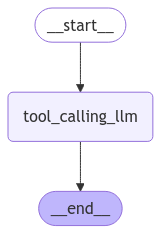

In [50]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

I'm happy to chat with you, but I don't see a specific question or task that requires a function call. If you have a math problem that involves multiplication, I can help you with that using the "multiply" function. Just let me know what you need help with!


In [58]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_f0ka)
 Call ID: call_f0ka
  Args:
    a: 2
    b: 3
